In [1]:
import os,sys,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import copy
import pdb
import time

from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

from datetime import datetime

_dtype_ = torch.float32
_device_ = torch.device("mps")

seq_len = 10
seq_len_ma = 10
seq_len_forward = 1

metrics = {}

class PP_MLP(nn.Module): # Price Pridiction

    def __init__(self, init_method = 'uniform'):

        super(PP_MLP, self).__init__() 
        self.layer1 = nn.Linear(14, 10)  
        self.layer2 = nn.Linear(10, 5)
        self.layer3 = nn.Linear(5, 3)
        self.output = nn.Linear(3, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        x = self.relu(self.layer1(x)) 
        x = self.relu(self.layer2(x)) 
        x = self.relu(self.layer3(x)) 
        return self.output(x) 
    
class PP_LSTM(nn.Module):
    def __init__(self, init_method='uniform'):

        super(PP_LSTM, self).__init__()
        self.hidden_dim = 10
        self.lstm = nn.LSTM(14, self.hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.dense_1 = nn.Linear(self.hidden_dim, 5)
        self.dense_2 = nn.Linear(5, 3)
        self.dense_3 = nn.Linear(3, 1)
        self.relu = nn.ReLU()

    def forward(self, x):

        lstm_out, _ = self.lstm(x)
        
        x = lstm_out[:, -1, :]
        x = self.dropout(x) 
        x = self.relu(self.dense_1(x))
        x = self.relu(self.dense_2(x))
        x = self.dense_3(x)
        
        return x
        
class H5Dataset(Dataset):
    def __init__(self, file_path, norm_flag):
        self.file_path = file_path
        self.dataset = {}

        with h5py.File(self.file_path, 'r') as file:
            self.dataset['inputs'] = file['inputs'][:]
            self.dataset['outputs'] = file['outputs'][:]
            

        if norm_flag == 'n':
            self.normalization()
        if norm_flag == 'd':
            pass
        
    
    def __len__(self):
        return len(self.dataset['inputs'])

    def __getitem__(self, idx):
        input_data = torch.tensor(self.dataset['inputs'][idx], dtype=torch.float32)
        output_data = torch.tensor(self.dataset['outputs'][idx], dtype=torch.float32)
        return input_data, output_data
    
    def normalization(self):
        inputs = self.dataset['inputs']
        outputs = self.dataset['outputs']
        min_vals_i = inputs.min(axis=0)  
        max_vals_i = inputs.max(axis=0) 
        min_vals_o = outputs.min(axis=0)  
        max_vals_o = outputs.max(axis=0)         

        ranges_i = max_vals_i - min_vals_i
        ranges_i[ranges_i == 0] = 1

        if (max_vals_o - min_vals_o)!= 0:
            ranges_o = max_vals_o - min_vals_o
        else:
            ranges_o = 1

        self.dataset['inputs'] = (inputs - min_vals_i) / ranges_i
        self.dataset['outputs'] = ((outputs - min_vals_o) / ranges_o).squeeze()

    def add_indices(self):
        inputs = self.dataset['inputs']
        indices = np.arange(inputs.shape[0]).reshape(-1, 1)
        self.dataset['inputs'] = np.hstack((indices, inputs))

def set_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def denormalize(dataset, model, input):
    outputs = dataset.dataset['outputs']
    min_vals_o = outputs.min(axis=0)  
    max_vals_o = outputs.max(axis=0)         

    range_o = max_vals_o - min_vals_o

    return (model(input)*range_o)+min_vals_o


def seq_gen(dataset, inputs, seq_len, device):

    inputs_o = torch.zeros(inputs.shape[0], seq_len, inputs.shape[1]-1)

    for i in range(inputs.shape[0]):

        idx_i = int(inputs[i][0].item())
        start_idx = max(0, idx_i - seq_len + 1)
        end_idx = idx_i + 1
        segment = dataset.dataset['inputs'][start_idx:end_idx, 1:]

        first_col = segment[:, 0]
        diff = np.diff(first_col)
        last_increasing_idx = np.where(diff <= 0)[0]
        if len(last_increasing_idx) > 0:
            cut_point = last_increasing_idx[-1] + 1
        else:
            cut_point = 0

        segment[:cut_point, :] = 0

        segment_tensor = torch.from_numpy(segment)

        fill_start = seq_len - (end_idx - start_idx)

        target_size = seq_len - fill_start
        
        if segment_tensor.shape[0] < target_size:
            padding_size = target_size - segment_tensor.shape[0]
            padding = torch.zeros(padding_size, segment_tensor.shape[1])
            segment_tensor = torch.cat([padding, segment_tensor], dim=0)
        
        
        
        inputs_o[i, fill_start:seq_len, :] = segment_tensor

    return inputs_o.to(device)

def SMA(array, window_length):

    sma = np.zeros(len(array))  

    for i in range(1, len(array)):
        if i < window_length:
            
            sma[i] = np.mean(array[:i])
        else:
            
            sma[i] = np.mean(array[i-window_length:i])
            
    return sma

def EMA(array, window_length):

    ema = np.zeros(len(array))  
    alpha = 2 / (window_length + 1)  

    ema[0] = 0 

    for i in range(1, len(array)):
        if i < window_length:

            temp_alpha = 2 / (i + 1)
            ema[i] = temp_alpha * array[i] + (1 - temp_alpha) * ema[i - 1]
        else:

            ema[i] = alpha * array[i] + (1 - alpha) * ema[i - 1]

    return ema


def moving_average(dataset, method, window_length):

    # method: 'SMA' for Simple Moving Average or 'EMA' for Exponential Moving Average
    outputs = dataset.dataset['outputs']
    time_series = dataset.dataset['inputs'][:, 1]
    segments = np.where(np.diff(time_series) < 0)[0] + 1

    start_index = 0
    results = []

    for end_index in segments:

        current_segment = outputs[start_index:end_index]

        if method == 'SMA':
            ma_values = SMA(current_segment, window_length)
        elif method == 'EMA':
            ma_values = EMA(current_segment, window_length)
        else:
            raise ValueError("Unsupported method. Use 'SMA' or 'EMA'.")

        results.append(ma_values)
        start_index = end_index

    if start_index < len(outputs):
        current_segment = outputs[start_index:]
        if method == 'SMA':
            ma_values = SMA(current_segment, window_length)
        elif method == 'EMA':
            ma_values = EMA(current_segment, window_length)
        results.append(ma_values)

    final_result = np.concatenate(results)
    return final_result




In [101]:
dataset_train = H5Dataset(f'../data/lob_data/lob_data_train_f{seq_len_forward}.h5','n')
dataset_train_dn = H5Dataset(f'../data/lob_data/lob_data_train_f{seq_len_forward}.h5','d')

dataset_verif = H5Dataset(f'../data/lob_data/lob_data_verif_f{seq_len_forward}.h5','n')
dataset_verif_dn = H5Dataset(f'../data/lob_data/lob_data_verif_f{seq_len_forward}.h5','d')

dataset_test = H5Dataset(f'../data/lob_data/lob_data_test_f{seq_len_forward}.h5','n')
dataset_test_dn = H5Dataset(f'../data/lob_data/lob_data_test_f{seq_len_forward}.h5','d')

dataset_train.add_indices()
dataset_verif.add_indices()
dataset_test.add_indices()

dataset_train_dn.add_indices()
dataset_verif_dn.add_indices()
dataset_test_dn.add_indices()

In [85]:
PPLSTM_model = PP_LSTM(init_method = 'uniform').to(_device_)

loader_train = DataLoader(dataset_train, batch_size = 4096, shuffle = True)
loader_verif = DataLoader(dataset_verif, batch_size = 4096, shuffle = True)

criterion = nn.MSELoss()
optimizer = optim.Adam(PPLSTM_model.parameters(), lr=0.00005, weight_decay=1e-5)

model_save_path_LSTM = f'PPLSTM_model_t{seq_len}.pt'
optimizer_save_path_LSTM = f'PPLSTM_optimizer_t{seq_len}.pt'

In [86]:
# LSTM Training using Time Window

continue_training = input("Do you want to continue training or start a new one? (c/n): ").lower() == 'c'

if continue_training and os.path.exists(model_save_path_LSTM) and os.path.exists(optimizer_save_path_LSTM):
    
    PPLSTM_model.load_state_dict(torch.load(model_save_path_LSTM))
    optimizer.load_state_dict(torch.load(optimizer_save_path_LSTM))
    
    print("Continue training from saved state.")
else:
    print("Start training from scratch.")

epoch_losses_train = []
epoch_losses_verif = []

max_epochs = 100

patience = 10

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

filename = f'LSTM_loss_train & verif_{timestamp}.dat'

filename_t = f'LSTM_time_cost_{timestamp}.dat'

with open(filename, 'w') as f:

    best_loss_verif = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):

        PPLSTM_model.train()

        t_start = time.time()

        running_loss_train = 0.0

        print(f"Start epoch {epoch+1}.\n")

        for batch_idx, (inputs, labels) in enumerate(loader_train):
    
            inputs, labels = seq_gen(dataset_train, inputs, seq_len, _device_), labels.to(_device_).unsqueeze(1)
            
            optimizer.zero_grad()

            outputs = PPLSTM_model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(PPLSTM_model.parameters(), max_norm = 1.0)

            optimizer.step()

            running_loss_train += loss.item()

            if ((batch_idx+1) % 500 == 0) or batch_idx == 0:

                print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Batch Loss_train: {loss.item()}")

        print('\n')

        PPLSTM_model.eval()

        with torch.no_grad():

            running_loss_verif = 0.0

            for batch_idx, (inputs, labels) in enumerate(loader_verif):

                inputs, labels = seq_gen(dataset_verif, inputs, seq_len, _device_), labels.to(_device_).unsqueeze(1)

                outputs = PPLSTM_model(inputs)

                loss = criterion(outputs, labels)

                running_loss_verif += loss.item()

        epoch_loss_train = running_loss_train/len(loader_train)
        epoch_loss_verif = running_loss_verif/len(loader_verif)

        epoch_losses_train.append(epoch_loss_train)
        epoch_losses_verif.append(epoch_loss_verif)

        # scheduler_step.step()

        f.write(f'Epoch {epoch+1}, Loss_train: {epoch_loss_train}, Loss_verif: {epoch_loss_verif}\n')
        print(f'Epoch {epoch+1}, Epoch Average Loss_train: {epoch_loss_train}, Epoch Average Loss_verif: {epoch_loss_verif}\n')

        t_end = time.time()
        t_duration = t_end - t_start

        with open(filename_t,'a') as f_t:
            f_t.write(f'Epoch {epoch+1} cost {t_duration} s.\n')

        if epoch_loss_verif < best_loss_verif:
            best_loss_verif = epoch_loss_verif
            patience_counter = 0
            torch.save(PPLSTM_model.state_dict(), model_save_path_LSTM)
            torch.save(optimizer.state_dict(), optimizer_save_path_LSTM)
        else :
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    
    print('\n')

Start training from scratch.
Start epoch 1.

Epoch 1, Batch 1, Batch Loss_train: 0.023919295519590378
Epoch 1, Batch 500, Batch Loss_train: 0.016119062900543213
Epoch 1, Batch 1000, Batch Loss_train: 0.011437781155109406
Epoch 1, Batch 1500, Batch Loss_train: 0.009081019088625908
Epoch 1, Batch 2000, Batch Loss_train: 0.00707754772156477
Epoch 1, Batch 2500, Batch Loss_train: 0.005547294393181801
Epoch 1, Batch 3000, Batch Loss_train: 0.005036527290940285
Epoch 1, Batch 3500, Batch Loss_train: 0.004656188189983368
Epoch 1, Batch 4000, Batch Loss_train: 0.004989151377230883


Epoch 1, Epoch Average Loss_train: 0.008665323196454206, Epoch Average Loss_verif: 0.0034591872109237757

Start epoch 2.

Epoch 2, Batch 1, Batch Loss_train: 0.004669835325330496
Epoch 2, Batch 500, Batch Loss_train: 0.004827868193387985
Epoch 2, Batch 1000, Batch Loss_train: 0.004225354176014662
Epoch 2, Batch 1500, Batch Loss_train: 0.00394150847569108
Epoch 2, Batch 2000, Batch Loss_train: 0.004101852886378765
E

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_69158/719028956.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, max(df['Loss_train']))


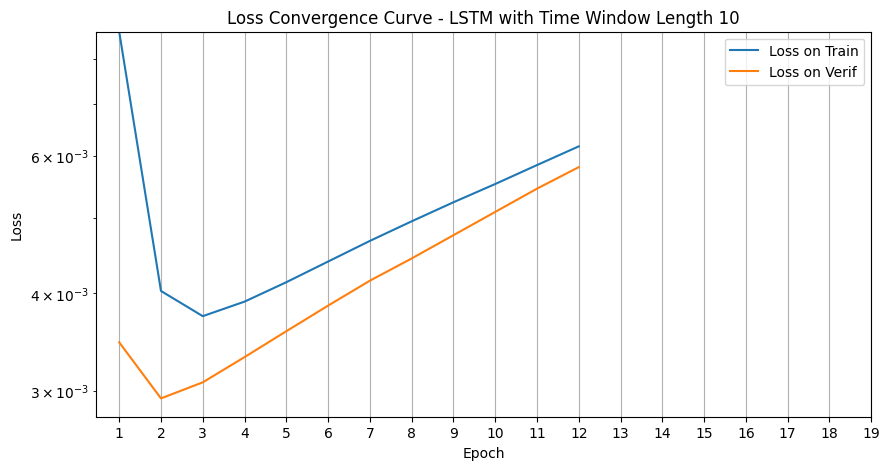

In [87]:

with open(filename, 'r') as file:
    loss_conv_f = file.readlines()
# Parsing the data to a DataFrame
loss_conv = {
    'Epoch': [],
    'Loss_train': [],
    'Loss_verif': []
}

# Split each line and extract values
for line in loss_conv_f:
    parts = line.strip().split(', ')
    epoch = int(parts[0].split(' ')[1])
    loss_train = float(parts[1].split(': ')[1])
    loss_verif = float(parts[2].split(': ')[1])
    
    loss_conv['Epoch'].append(epoch)
    loss_conv['Loss_train'].append(loss_train)
    loss_conv['Loss_verif'].append(loss_verif)

df = pd.DataFrame(loss_conv)

plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Loss_train'], label='Loss on Train')
plt.plot(df['Epoch'], df['Loss_verif'], label='Loss on Verif')
plt.title(f'Loss Convergence Curve - LSTM with Time Window Length {seq_len}')
plt.xlabel('Epoch')
plt.xticks(np.arange(1, 20, 1))
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim(0, max(df['Loss_train']))
plt.legend()
plt.grid(True)
plt.savefig(f'LSTM Loss Convergence T{seq_len}.pdf', format='pdf')
plt.show()

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_69158/1157559316.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PPLSTM_model.load_state_dict(torch.load(model

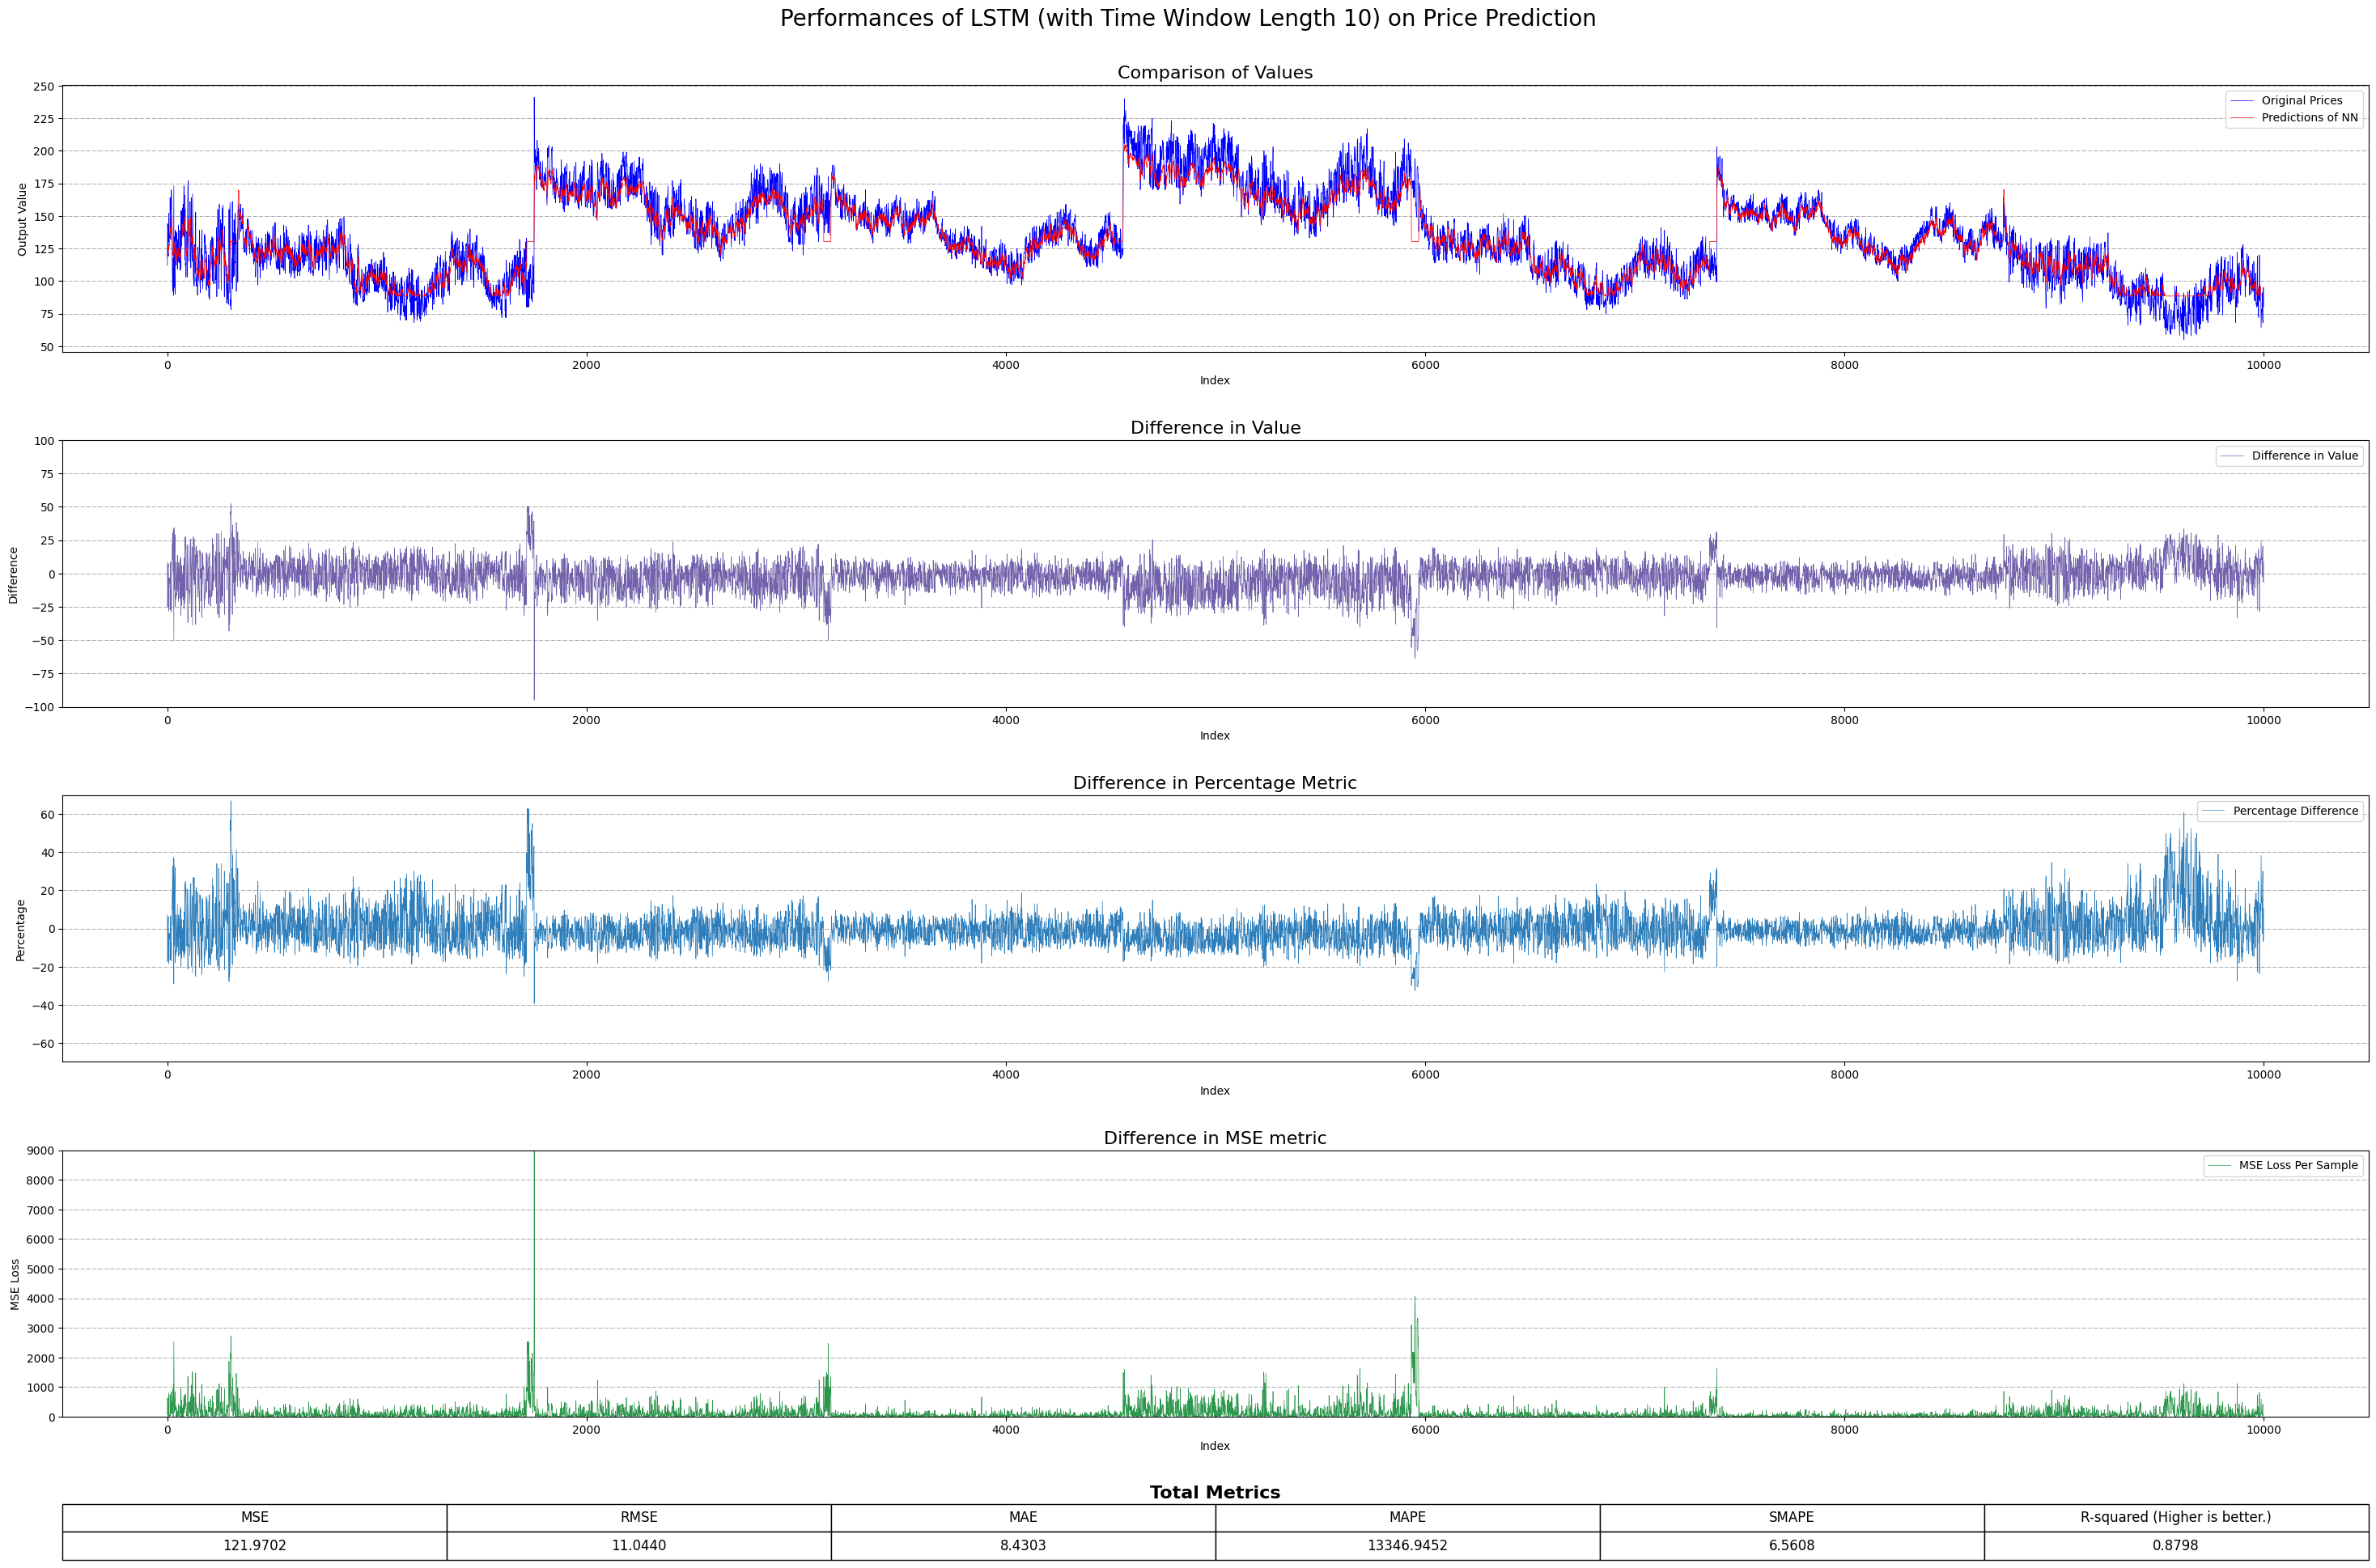

In [88]:
# LSTM Plot

seq_len = 10

model_save_path_LSTM = f'PPLSTM_model_t{seq_len}.pt'
optimizer_save_path_LSTM = f'PPLSTM_optimizer_t{seq_len}.pt'

PPLSTM_model = PP_LSTM(init_method = 'uniform').to(_device_)
PPLSTM_model.load_state_dict(torch.load(model_save_path_LSTM))
PPLSTM_model.eval()

# Collection of Data

section_len = 10000
section_start = 492500

if (section_start + section_len > len(dataset_test_dn.dataset['outputs'])):
    raise ValueError('Length Overflow: The requested section exceeds the available data size.')

inputs = torch.tensor(dataset_test.dataset['inputs'][section_start:section_start + section_len])

outputs_original = dataset_test_dn.dataset['outputs'][section_start:section_start + section_len].squeeze()
outputs_NN = denormalize(dataset_test_dn, PPLSTM_model, seq_gen(dataset_test, inputs, seq_len, _device_)).cpu().detach().numpy().squeeze()

diffs_in_val = outputs_NN - outputs_original

diffs_in_percent = np.where(outputs_original != 0, 
                            (outputs_NN - outputs_original) / outputs_original * 100, 
                            0)

criterion_no_reduction = nn.MSELoss(reduction='none')
diffs_in_loss = criterion_no_reduction(torch.tensor(outputs_NN, dtype=torch.float32), 
                                       torch.tensor(outputs_original, dtype=torch.float32)).detach().numpy()


metrics[f'LSTM_{seq_len}'] = {
    'MSE': np.mean((outputs_original - outputs_NN) ** 2),
    'RMSE': np.sqrt(np.mean((outputs_original - outputs_NN) ** 2)),
    'MAE': np.mean(np.abs(outputs_original - outputs_NN)),
    'MAPE': np.mean(np.abs((outputs_original - outputs_NN/outputs_original)))*100,
    'SMAPE': 100 * np.mean(2 * np.abs(outputs_NN - outputs_original) / (np.abs(outputs_NN) + np.abs(outputs_original))),
    'R-squared': 1 - (np.sum((outputs_original - outputs_NN) ** 2) / np.sum((outputs_original - np.mean(outputs_original)) ** 2)),
}

fig, axs = plt.subplots(5, 1, figsize=(30, 20), gridspec_kw={'height_ratios': [1, 1, 1, 1, 0.2]})  


axs[0].plot(outputs_original, label='Original Prices', color='blue',linewidth=0.5)
axs[0].plot(outputs_NN, label='Predictions of NN', color='red',linewidth=0.5)
axs[0].set_title('Comparison of Values',fontsize = 16)
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Output Value')
axs[0].legend()

axs[1].plot(diffs_in_val, label='Difference in Value', color='#7262ac',linewidth=0.5)
axs[1].set_title('Difference in Value',fontsize = 16)
axs[1].set_ylim(-100, 100)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Difference')
axs[1].legend()

axs[2].plot(diffs_in_percent, label='Percentage Difference', color='#2e7ebb',linewidth=0.5)
axs[2].set_title('Difference in Percentage Metric', fontsize = 16)
axs[2].set_ylim(-70, 70)
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Percentage')
axs[2].legend()

axs[3].plot(diffs_in_loss, label='MSE Loss Per Sample', color='#2e974e',linewidth=0.5)
axs[3].set_title('Difference in MSE metric', fontsize = 16)
axs[3].set_ylim(0, 9000)
axs[3].set_xlabel('Index')
axs[3].set_ylabel('MSE Loss')
axs[3].legend()

cell_text = [[f"{v:.4f}" for v in metrics[f'LSTM_{seq_len}'].values()]]
columns = list(metrics[f'LSTM_{seq_len}'].keys())
columns[-1]+=' (Higher is better.)'

axs[4].set_title('Total Metrics', fontweight='bold', fontsize=16)

axs[4].axis('tight')
axs[4].axis('off')
table = axs[4].table(cellText=cell_text, colLabels=columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

for ax_i in axs:
    ax_i.grid(True, axis = 'y', linestyle='-.', linewidth=0.5, color='gray')

plt.suptitle(f'Performances of LSTM (with Time Window Length {seq_len}) on Price Prediction',fontsize = 20)
fig.tight_layout(pad=3.0)
plt.savefig(f'LSTM-T{seq_len} Performances.pdf', format='pdf')
plt.show()

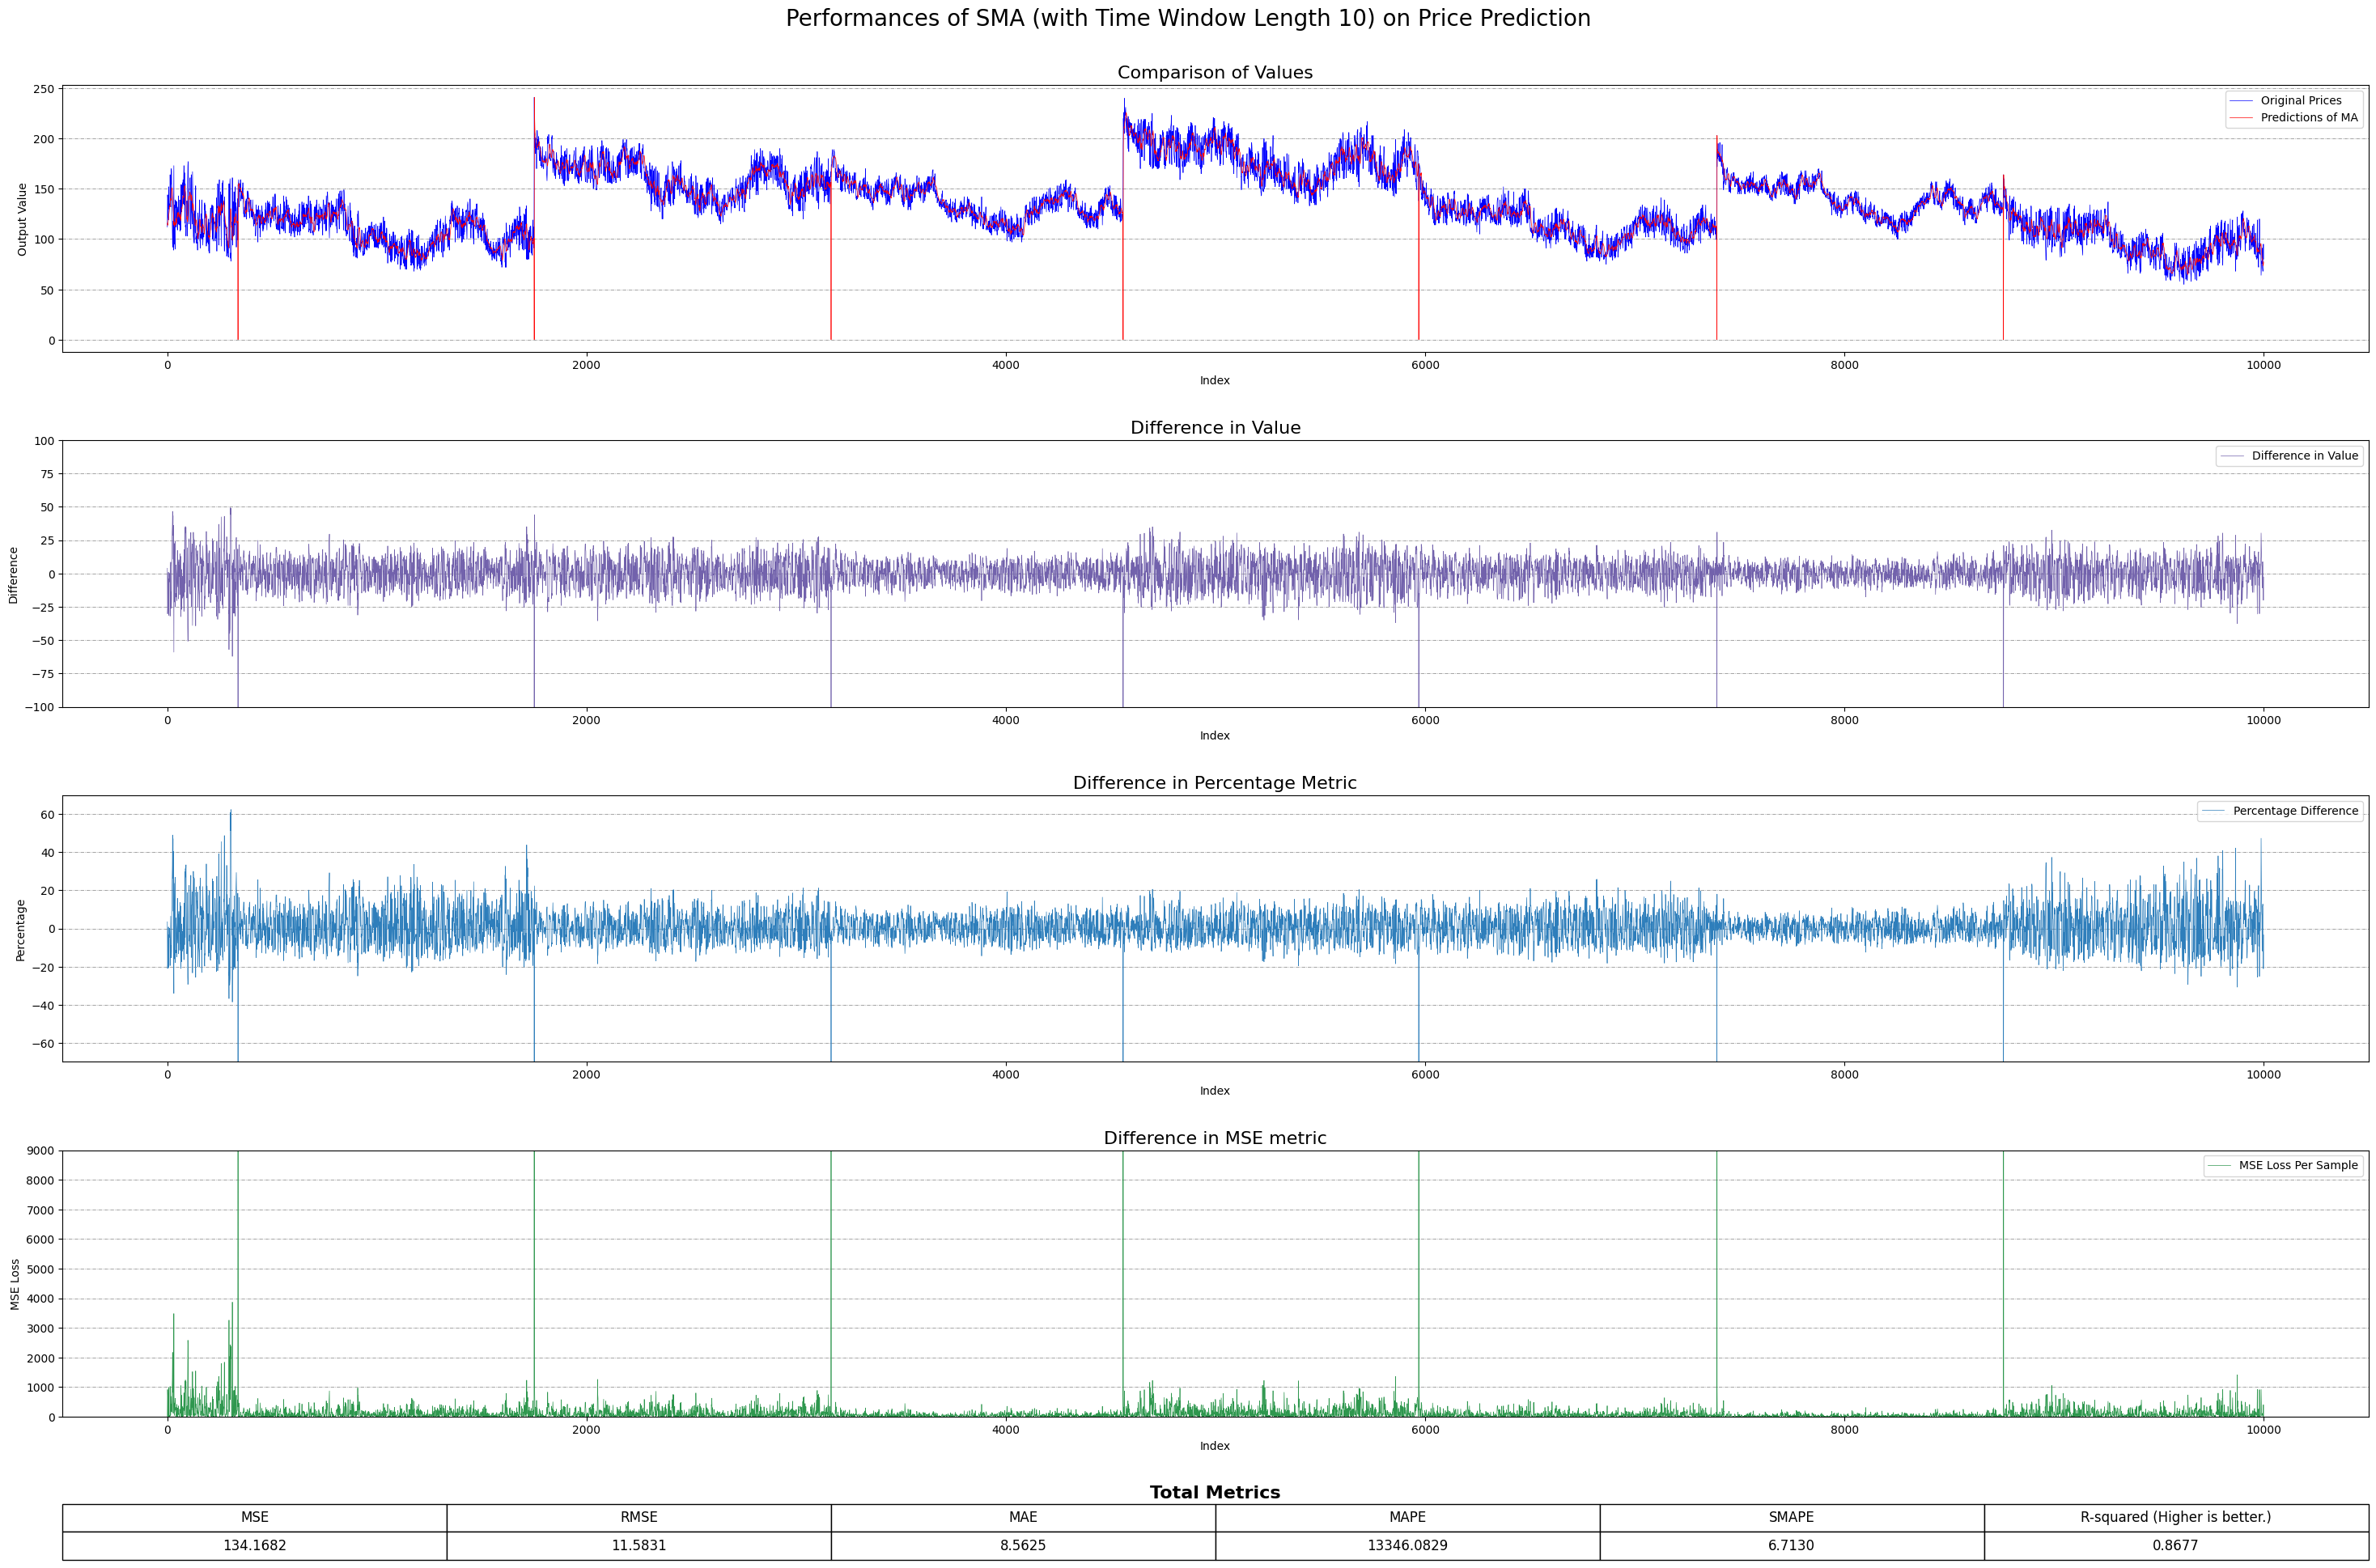

In [76]:
# Moving Averaging Plots

section_len = 10000
section_start = 492500

if (section_start + section_len > len(dataset_test_dn.dataset['outputs'])):
    raise ValueError('Length Overflow: The requested section exceeds the available data size.')

outputs_original = dataset_test_dn.dataset['outputs'][section_start:section_start + section_len].squeeze()

method_MA = 'SMA'
outputs_MA = moving_average(dataset_test_dn, method_MA, seq_len_ma)[section_start:section_start + section_len].squeeze()

diffs_in_val = outputs_MA - outputs_original

diffs_in_percent = np.where(outputs_original != 0, 
                            (outputs_MA - outputs_original) / outputs_original * 100, 
                            0)

criterion_no_reduction = nn.MSELoss(reduction='none')
diffs_in_loss = criterion_no_reduction(torch.tensor(outputs_MA, dtype=torch.float32), 
                                       torch.tensor(outputs_original, dtype=torch.float32)).detach().numpy()


metrics[f'{method_MA}_{seq_len_ma}'] = {
    'MSE': np.mean((outputs_original - outputs_MA) ** 2),
    'RMSE': np.sqrt(np.mean((outputs_original - outputs_MA) ** 2)),
    'MAE': np.mean(np.abs(outputs_original - outputs_MA)),
    'MAPE': np.mean(np.abs((outputs_original - outputs_MA/outputs_original)))*100,
    'SMAPE': 100 * np.mean(2 * np.abs(outputs_MA - outputs_original) / (np.abs(outputs_MA) + np.abs(outputs_original))),
    'R-squared': 1 - (np.sum((outputs_original - outputs_MA) ** 2) / np.sum((outputs_original - np.mean(outputs_original)) ** 2)),
}


fig, axs = plt.subplots(5, 1, figsize=(30, 20), gridspec_kw={'height_ratios': [1, 1, 1, 1, 0.2]})  


axs[0].plot(outputs_original, label='Original Prices', color='blue',linewidth=0.5)
axs[0].plot(outputs_MA, label='Predictions of MA', color='red',linewidth=0.5)
axs[0].set_title('Comparison of Values',fontsize = 16)
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Output Value')
axs[0].legend()

axs[1].plot(diffs_in_val, label='Difference in Value', color='#7262ac',linewidth=0.5)
axs[1].set_title('Difference in Value',fontsize = 16)
axs[1].set_ylim(-100, 100)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Difference')
axs[1].legend()

axs[2].plot(diffs_in_percent, label='Percentage Difference', color='#2e7ebb',linewidth=0.5)
axs[2].set_title('Difference in Percentage Metric', fontsize = 16)
axs[2].set_ylim(-70, 70)
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Percentage')
axs[2].legend()

axs[3].plot(diffs_in_loss, label='MSE Loss Per Sample', color='#2e974e',linewidth=0.5)
axs[3].set_title('Difference in MSE metric', fontsize = 16)
axs[3].set_ylim(0, 9000)
axs[3].set_xlabel('Index')
axs[3].set_ylabel('MSE Loss')
axs[3].legend()

cell_text = [[f"{v:.4f}" for v in metrics[f'{method_MA}_{seq_len_ma}'].values()]]
columns = list(metrics[f'{method_MA}_{seq_len_ma}'].keys())
columns[-1]+=' (Higher is better.)'

axs[4].set_title('Total Metrics', fontweight='bold', fontsize=16)

axs[4].axis('tight')
axs[4].axis('off')
table = axs[4].table(cellText=cell_text, colLabels=columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

for ax_i in axs:
    ax_i.grid(True, axis = 'y', linestyle='-.', linewidth=0.5, color='gray')

plt.suptitle(f'Performances of {method_MA} (with Time Window Length {seq_len_ma}) on Price Prediction',fontsize = 20)
fig.tight_layout(pad=3.0)
plt.savefig(f'{method_MA}-T{seq_len_ma} Performances.pdf', format='pdf')
plt.show()

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_69158/2912212724.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  PPMLP_model.load_state_dict(torch.load(model_

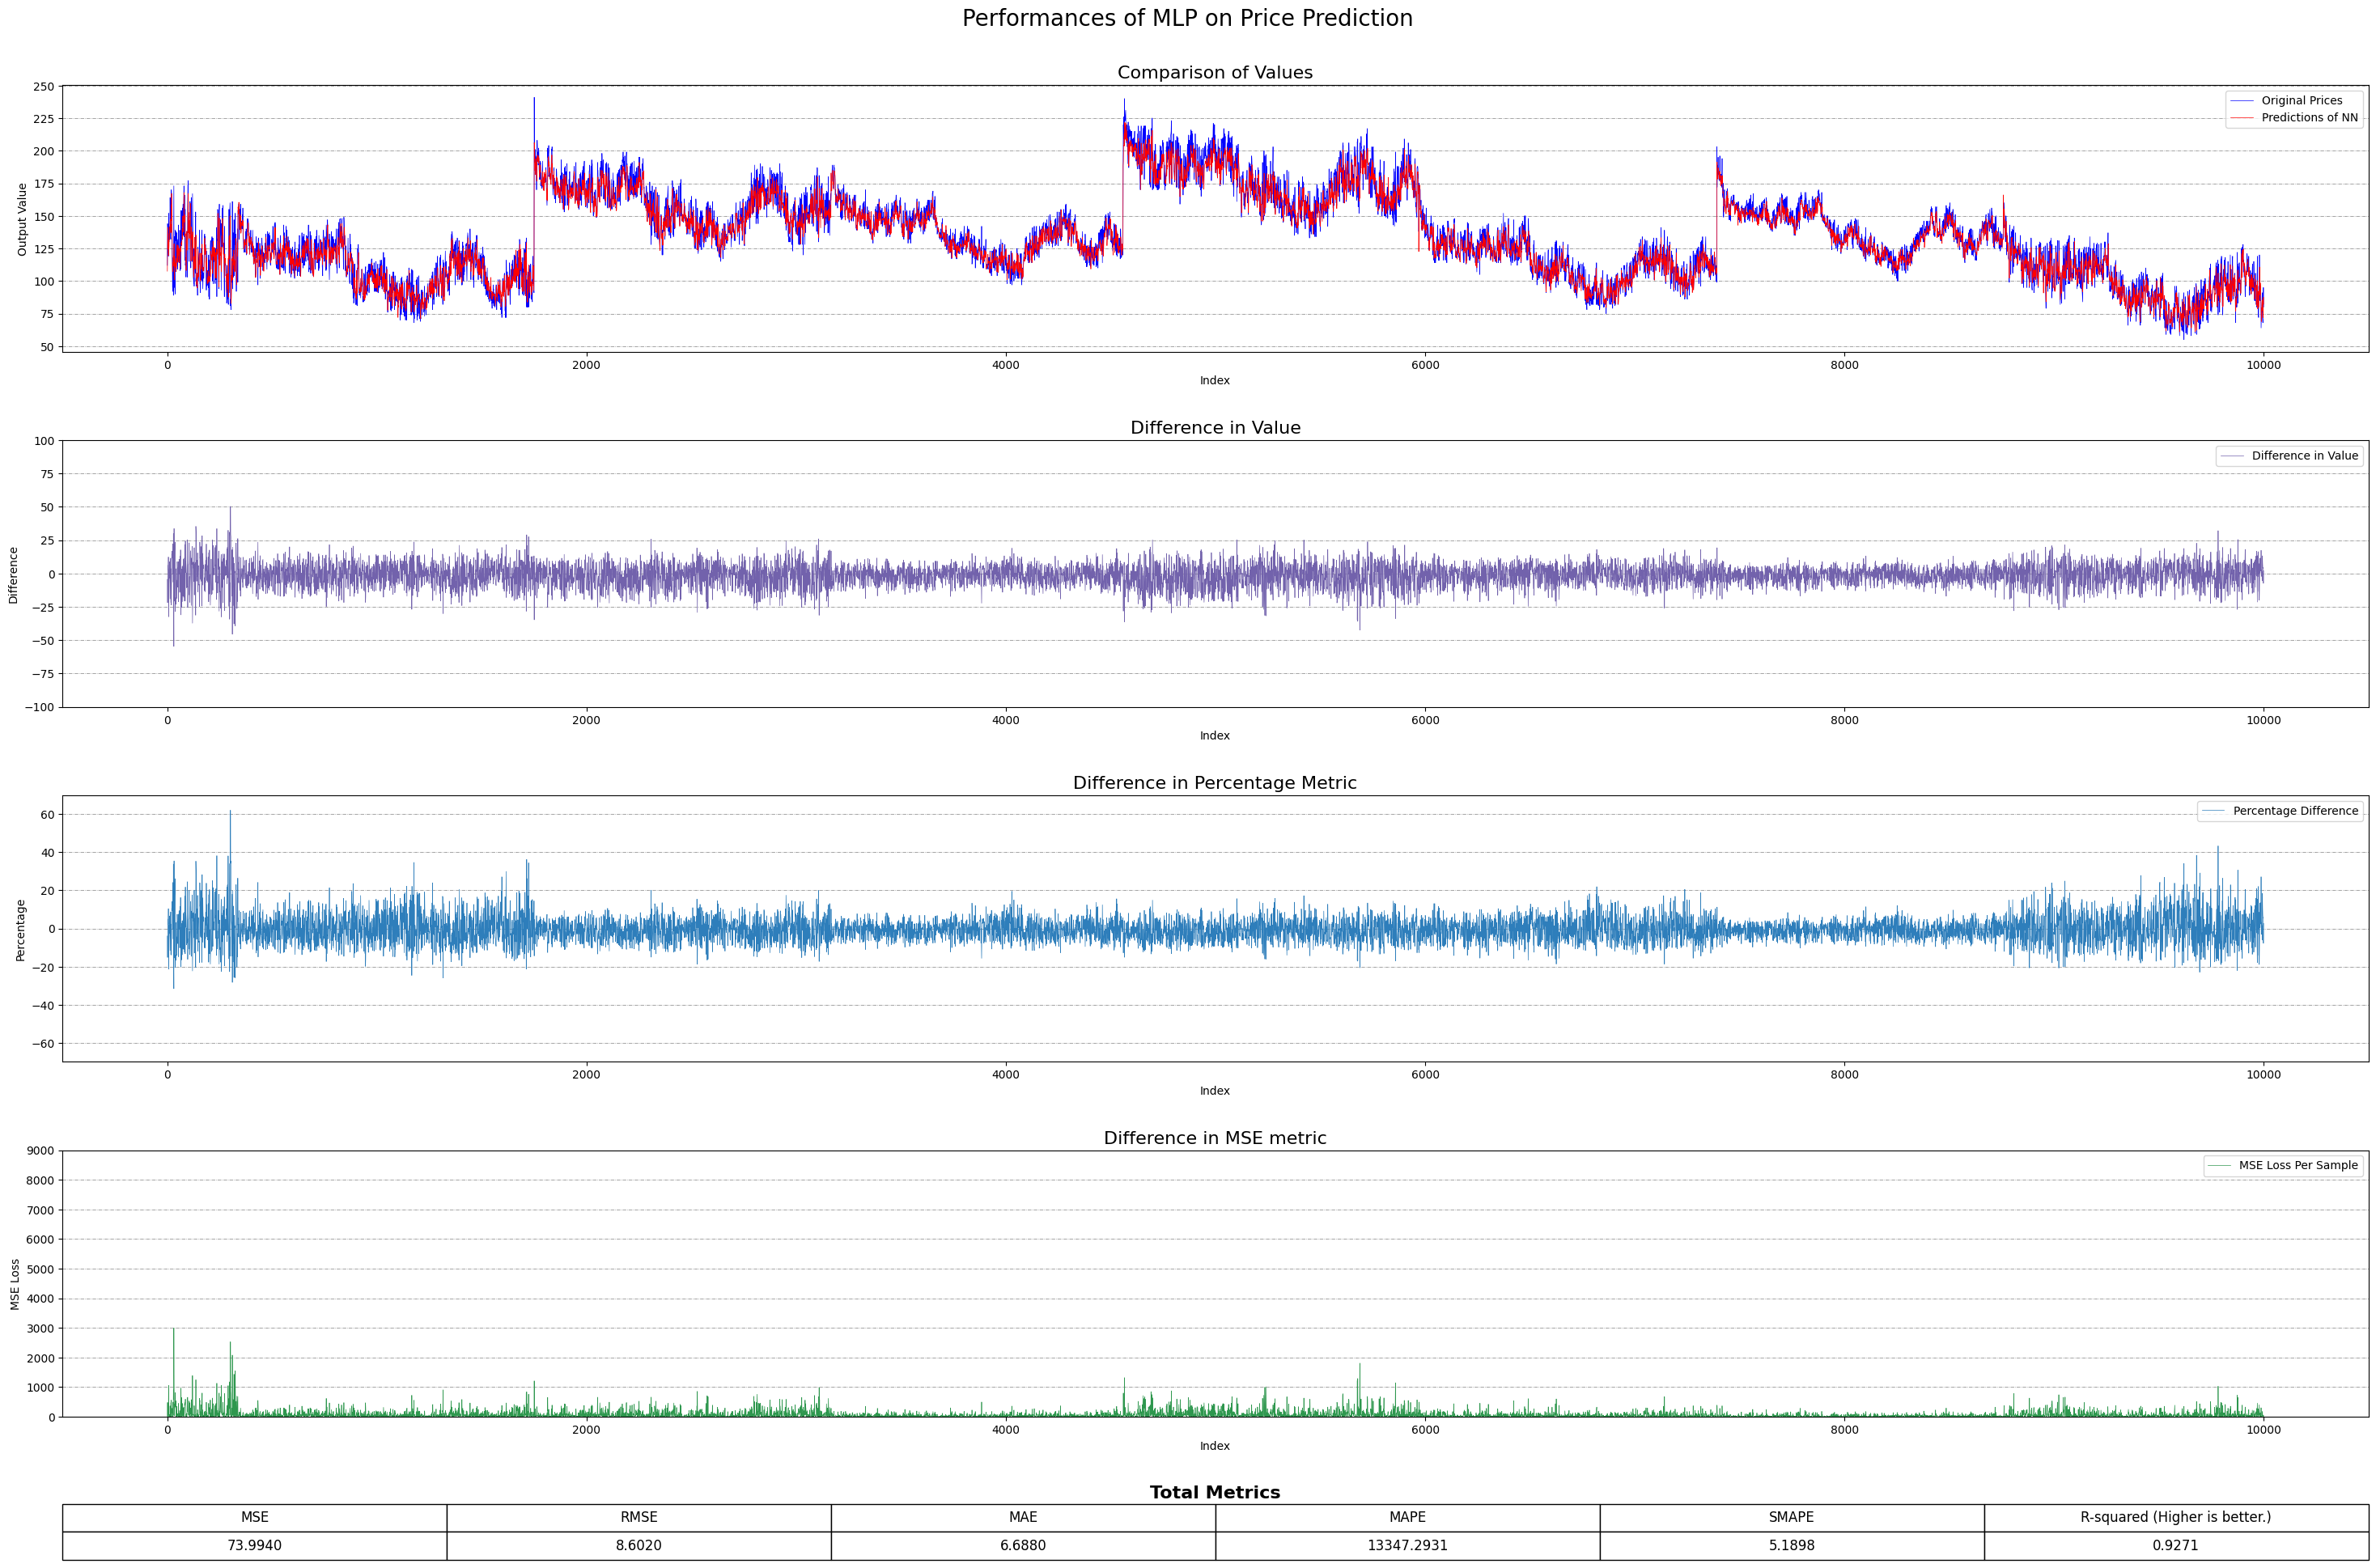

In [73]:
# MLP Plot

model_save_path_MLP = f'PPMLP_model.pt'
optimizer_save_path_MLP = f'PPMLP_optimizer.pt'

PPMLP_model = PP_MLP(init_method = 'uniform').to('cpu')
PPMLP_model.load_state_dict(torch.load(model_save_path_MLP))
PPMLP_model.eval()
# Collection of Data

section_len = 10000
section_start = 492500

dataset_test_MLP = H5Dataset('../data/lob_data/lob_data_test.h5','n')

if (section_start + section_len > len(dataset_test_dn.dataset['outputs'])):
    raise ValueError('Length Overflow: The requested section exceeds the available data size.')

inputs = torch.tensor(dataset_test_MLP.dataset['inputs'][section_start:section_start + section_len], dtype=torch.float32)

outputs_original = dataset_test_dn.dataset['outputs'][section_start:section_start + section_len].squeeze()
outputs_NN = denormalize(dataset_test_dn, PPMLP_model, inputs).detach().numpy().squeeze()

diffs_in_val = outputs_NN - outputs_original

diffs_in_percent = np.where(outputs_original != 0, 
                            (outputs_NN - outputs_original) / outputs_original * 100, 
                            0)

criterion_no_reduction = nn.MSELoss(reduction='none')
diffs_in_loss = criterion_no_reduction(torch.tensor(outputs_NN, dtype=torch.float32), 
                                       torch.tensor(outputs_original, dtype=torch.float32)).detach().numpy()

metrics['MLP'] = {
    'MSE': np.mean((outputs_original - outputs_NN) ** 2),
    'RMSE': np.sqrt(np.mean((outputs_original - outputs_NN) ** 2)),
    'MAE': np.mean(np.abs(outputs_original - outputs_NN)),
    'MAPE': np.mean(np.abs((outputs_original - outputs_NN/outputs_original)))*100,
    'SMAPE': 100 * np.mean(2 * np.abs(outputs_NN - outputs_original) / (np.abs(outputs_NN) + np.abs(outputs_original))),
    'R-squared': 1 - (np.sum((outputs_original - outputs_NN) ** 2) / np.sum((outputs_original - np.mean(outputs_original)) ** 2)),
}

fig, axs = plt.subplots(5, 1, figsize=(30, 20), gridspec_kw={'height_ratios': [1, 1, 1, 1, 0.2]})  


axs[0].plot(outputs_original, label='Original Prices', color='blue',linewidth=0.5)
axs[0].plot(outputs_NN, label='Predictions of NN', color='red',linewidth=0.5)
axs[0].set_title('Comparison of Values',fontsize = 16)
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Output Value')
axs[0].legend()

axs[1].plot(diffs_in_val, label='Difference in Value', color='#7262ac',linewidth=0.5)
axs[1].set_title('Difference in Value',fontsize = 16)
axs[1].set_ylim(-100, 100)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Difference')
axs[1].legend()

axs[2].plot(diffs_in_percent, label='Percentage Difference', color='#2e7ebb',linewidth=0.5)
axs[2].set_title('Difference in Percentage Metric', fontsize = 16)
axs[2].set_ylim(-70, 70)
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Percentage')
axs[2].legend()

axs[3].plot(diffs_in_loss, label='MSE Loss Per Sample', color='#2e974e',linewidth=0.5)
axs[3].set_title('Difference in MSE metric', fontsize = 16)
axs[3].set_ylim(0, 9000)
axs[3].set_xlabel('Index')
axs[3].set_ylabel('MSE Loss')
axs[3].legend()

cell_text = [[f"{v:.4f}" for v in metrics['MLP'].values()]]
columns = list(metrics['MLP'].keys())
columns[-1]+=' (Higher is better.)'
axs[4].set_title('Total Metrics', fontweight='bold', fontsize=16)

axs[4].axis('tight')
axs[4].axis('off')
table = axs[4].table(cellText=cell_text, colLabels=columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

for ax_i in axs:
    ax_i.grid(True, axis = 'y', linestyle='-.', linewidth=0.5, color='gray')

plt.suptitle(f'Performances of MLP on Price Prediction',fontsize = 20)
fig.tight_layout(pad=3.0)
plt.savefig(f'MLP Performances.pdf', format='pdf')
plt.show()

In [91]:
trial = np.array([0,1,2,3,4,5,6])
diffs = np.diff(trial)
end_of_cycle_indices = np.where(diffs < 0)[0]

In [99]:
import numpy as np

def sliding_window(arr, window_size):
    # 计算滑动窗口的数量
    num_windows = len(arr) - window_size + 1
    # 使用 NumPy 的 stride_tricks 来创建滑动窗口
    return np.lib.stride_tricks.sliding_window_view(arr, window_shape=window_size)

# 示例数组
array = np.linspace(0,20,21)
# 指定窗口大小
n = 4

# 获取滑动窗口结果
result = sliding_window(array[1:], n)
print(result)

[[ 1.  2.  3.  4.]
 [ 2.  3.  4.  5.]
 [ 3.  4.  5.  6.]
 [ 4.  5.  6.  7.]
 [ 5.  6.  7.  8.]
 [ 6.  7.  8.  9.]
 [ 7.  8.  9. 10.]
 [ 8.  9. 10. 11.]
 [ 9. 10. 11. 12.]
 [10. 11. 12. 13.]
 [11. 12. 13. 14.]
 [12. 13. 14. 15.]
 [13. 14. 15. 16.]
 [14. 15. 16. 17.]
 [15. 16. 17. 18.]
 [16. 17. 18. 19.]
 [17. 18. 19. 20.]]


In [98]:
array[:-n]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])